In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import pandas as pd
from collections import Counter

### Data Preperation

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,x,y,color
0,-4.956506,25.706334,0.0
1,2.897218,10.359784,0.0
2,-4.488273,22.113311,0.0
3,3.823152,15.665060,0.0
4,4.425201,21.118726,0.0


### Dataset Class

In [3]:
class Colors(Dataset):
    def __init__(self,path, transform=None, shuffle=False):
        self.path = path
        self.transform = transform
        self.dataFrame = pd.read_csv(path)
        self.xy = pd.read_csv(path).values
        self.shuffle = shuffle
        
        if self.shuffle:
            np.random.shuffle(self.xy)
            
        self.x = self.xy[:, :2]
        self.y = self.xy [:, -1]
        self.len = self.y.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def plot(self):
        sns.scatterplot(data=self.dataFrame, x='x', y='y',hue='color')
        plt.show()

In [4]:
class ToTensor:
    def __call__(self, samples):
        x, y = samples
        return torch.Tensor(x.astype('float32')), torch.Tensor(np.array(y).astype('float32'))

In [5]:
train = Colors(
    'data/train.csv',
    transform =ToTensor(),
    shuffle=True
)
test = Colors(
    'data/test.csv',
    ToTensor(),
    shuffle=True
)

In [6]:
train[:6]

(tensor([[ 2.3718e+00,  7.1995e+00],
         [ 1.2556e-02, -1.7475e+00],
         [ 1.2472e+00,  3.4327e+00],
         [-4.4415e+00,  2.1569e+01],
         [ 5.3967e-01, -1.6546e+00],
         [ 1.5672e+00,  5.7890e-01]]),
 tensor([0., 1., 0., 0., 1., 1.]))

> Train Data

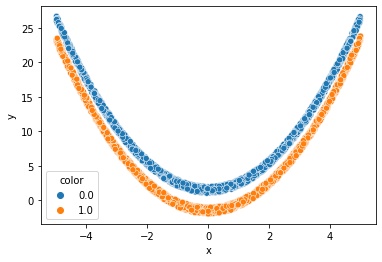

In [7]:
train.plot()

> Test data:

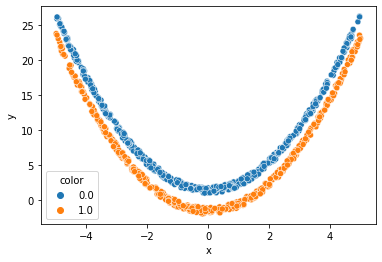

(None, 1000)

In [8]:
test.plot(), len(test)

### Data Loading to the Network using the DataLoader from ``torch.utis.data``

In [9]:
train_set = DataLoader(dataset=train,
                      batch_size =5,
                      shuffle=True)
test_set = DataLoader(dataset=test,
                      batch_size =5,
                      shuffle=False)

### Model Creation - Binary Classification `FFNN`

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()
net

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [11]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [12]:
EPOCHS = 100
for epoch in range(EPOCHS):
    for data in train_set:
        X, y = data
        optimizer.zero_grad()
        # forward pass 
        outputs = net(X.view(-1, 2))
        # loss calc
        loss = criterion(outputs.view(-1, 1), y.unsqueeze(1))
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step() 
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f"loss: {loss.item():.3f}")
        

Epoch 10/100
loss: 0.007
Epoch 20/100
loss: 0.002
Epoch 30/100
loss: 0.271
Epoch 40/100
loss: 0.001
Epoch 50/100
loss: 0.001
Epoch 60/100
loss: 0.000
Epoch 70/100
loss: 0.000
Epoch 80/100
loss: 0.000
Epoch 90/100
loss: 0.000
Epoch 100/100
loss: 0.002


### Model Evaluation

In [13]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_set:
        X, y = data
        y = y.unsqueeze(1)
        output = torch.round(net(X.view(-1, 2)))
        for i in range(len(output)):
            if output[i] == y[i]:
                correct +=1
            total+=1
    print("Accuracy: ", correct/total)

Accuracy:  1.0


### Making Predictions

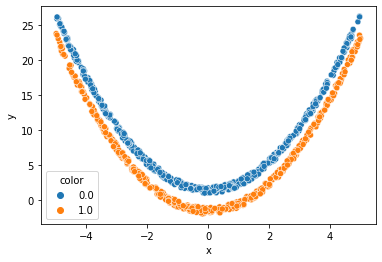

In [14]:
test.plot()

In [15]:
pred = net(torch.Tensor([-2, 0]).view(-1, 2)).detach()
pred

tensor([[1.]])